Accuracy =  91.66666666666666  
Vali set: Loss: 0.2278, Accuracy: 525/571 (92%)


# `densenet`
- DenseNet models, with weights pre-trained on ImageNet. This model and can be built both with 'channels_first' data format(channels, height, width) or 'channels_last' data format(height, width, channels). The default input size for this model is 224x224.
- https://scisharp.github.io/Keras.NET/api/Keras.Applications.DenseNet.DenseNet121.html#:~:text=DenseNet%20models%2C%20with%20weights%20pre,for%20this%20model%20is%20224x224.
- other torch models : https://pytorch.org/vision/0.8/models.html

# module import

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision
from torchvision.models import densenet161, densenet201
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import timm
import cv2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

# 1. Data  (unzip train/test dataset)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EWHA/Term Project/train.csv')
df = df.iloc[:, 1:4]
df = df.rename(columns={'cat':'label'})
df.head()

,id,img_path,label
0,TRAIN_0,./train/TRAIN_0.jpg,0
1,TRAIN_1,./train/TRAIN_1.jpg,0
2,TRAIN_2,./train/TRAIN_2.jpg,0
3,TRAIN_3,./train/TRAIN_3.jpg,0
4,TRAIN_4,./train/TRAIN_4.jpg,0


In [ ]:
df['label'].unique() # [국, 탕, 찌개] 순.

array([0, 1, 2])

In [ ]:
!mkdir data

In [ ]:
%cd /content/data

/content/data


In [ ]:
!mkdir train
!mkdir test

In [ ]:
%cd /content/data/train

/content/data/train


In [ ]:
!unzip "/content/drive/MyDrive/EWHA/Term Project/train.zip"

Archive:  /content/drive/MyDrive/EWHA/Term Project/train.zip
   creating: content/train/
  inflating: content/train/TRAIN_678  
  inflating: content/train/TRAIN_2201  
  inflating: content/train/TRAIN_409  
  inflating: content/train/TRAIN_1037  
  inflating: content/train/TRAIN_987  
  inflating: content/train/TRAIN_270  
  inflating: content/train/TRAIN_1261  
  inflating: content/train/TRAIN_965  
  inflating: content/train/TRAIN_441  
  inflating: content/train/TRAIN_2004  
  inflating: content/train/TRAIN_1820  
  inflating: content/train/TRAIN_1109  
  inflating: content/train/TRAIN_583  
  inflating: content/train/TRAIN_1775  
  inflating: content/train/TRAIN_474  
  inflating: content/train/TRAIN_793  
  inflating: content/train/TRAIN_131  
  inflating: content/train/TRAIN_484  
  inflating: content/train/TRAIN_455  
  inflating: content/train/TRAIN_141  
  inflating: content/train/TRAIN_1948  
  inflating: content/train/TRAIN_1402  
  inflating: content/train/TRAIN_1349  
  in

In [ ]:
%cd /content/data/test

/content/data/test


In [ ]:
!unzip "/content/drive/MyDrive/EWHA/Term Project/test.zip"

Archive:  /content/drive/MyDrive/EWHA/Term Project/test.zip
   creating: content/test/
  inflating: content/test/TEST_44    
  inflating: content/test/TEST_5     
  inflating: content/test/TEST_23    
  inflating: content/test/TEST_41    
  inflating: content/test/TEST_64    
  inflating: content/test/TEST_110   
  inflating: content/test/TEST_97    
  inflating: content/test/TEST_33    
  inflating: content/test/TEST_45    
  inflating: content/test/TEST_7     
  inflating: content/test/TEST_78    
  inflating: content/test/TEST_87    
  inflating: content/test/TEST_72    
  inflating: content/test/TEST_86    
  inflating: content/test/TEST_85    
  inflating: content/test/TEST_77    
  inflating: content/test/TEST_49    
  inflating: content/test/TEST_71    
  inflating: content/test/TEST_24    
  inflating: content/test/TEST_83    
  inflating: content/test/TEST_27    
  inflating: content/test/TEST_15    
  inflating: content/test/TEST_108   
  inflating: content/test/TEST_52    
 

png 확장자 붙이기

In [ ]:
import os

directory_path = '/content/data/train/content/train/'
desired_extension = '.png'
files = os.listdir(directory_path)

for file in files:
    if not file.endswith(desired_extension):
        new_name = file + desired_extension

        # Build the full paths for the old and new names
        old_path = os.path.join(directory_path, file)
        new_path = os.path.join(directory_path, new_name)

        os.rename(old_path, new_path)

print("File extensions added to all training images.")

File extensions added to all training images.


In [ ]:
directory_path = '/content/data/test/content/test/'

desired_extension = '.png'

files = os.listdir(directory_path)

for file in files:
    if not file.endswith(desired_extension):
        new_name = file + desired_extension

        old_path = os.path.join(directory_path, file)
        new_path = os.path.join(directory_path, new_name)

        os.rename(old_path, new_path)

print("File extensions added to all training images.")

File extensions added to all training images.


In [ ]:
import os
from glob import glob

# 데이터 로딩용 함수 정의
def get_train_data(data_dir):
    """
    return:
      - img_path_list : 이미지 저장 폴더 경로 리스트
      - label_list : 레이블 리스트
    """
    img_path_list = []
    label_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('_')[-1].split('.')[0]))

    # get label
    label_list.extend(df['label'])

    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('_')[-1].split('.')[0]))

    return img_path_list

## Check Data

In [ ]:
all_img_path, all_label = get_train_data('/content/data/train/content/train')
test_img_path = get_test_data('/content/data/test/content/test')

In [ ]:
all_label[-10:-5]

[2, 2, 2, 2, 2]

In [ ]:
all_img_path[-10:-5]

['/content/data/train/content/train/TRAIN_2270.png',
 '/content/data/train/content/train/TRAIN_2271.png',
 '/content/data/train/content/train/TRAIN_2272.png',
 '/content/data/train/content/train/TRAIN_2273.png',
 '/content/data/train/content/train/TRAIN_2274.png']

In [ ]:
test_img_path[:5]

['/content/data/test/content/test/TEST_0.png',
 '/content/data/test/content/test/TEST_1.png',
 '/content/data/test/content/test/TEST_2.png',
 '/content/data/test/content/test/TEST_3.png',
 '/content/data/test/content/test/TEST_4.png']

In [ ]:
from collections import Counter
cnt = Counter(all_label)
print(cnt)

Counter({1: 1140, 2: 570, 0: 569})


# 2. Settings (Hyperparameters)

In [ ]:
import platform
print(platform.platform())

# Determine if a GPU with CUDA support is available and use it; otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
print(f"Using {device} device.\n")

Linux-5.15.120+-x86_64-with-glibc2.35
Using cuda device.



In [ ]:
CFG = {
    'IMG_SIZE':224,
    'MODEL_NAME':'densenet161',
    'EPOCHS':10, #25,10
    'LEARNING_RATE':0.00005, #2e-4,
    'BATCH_SIZE':8, #12,8
    'SEED':42,
    'CLASSES':3
}

In [ ]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 3. Data Preprocessing

## 1) Custom dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) ### RGB로 재변환

        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

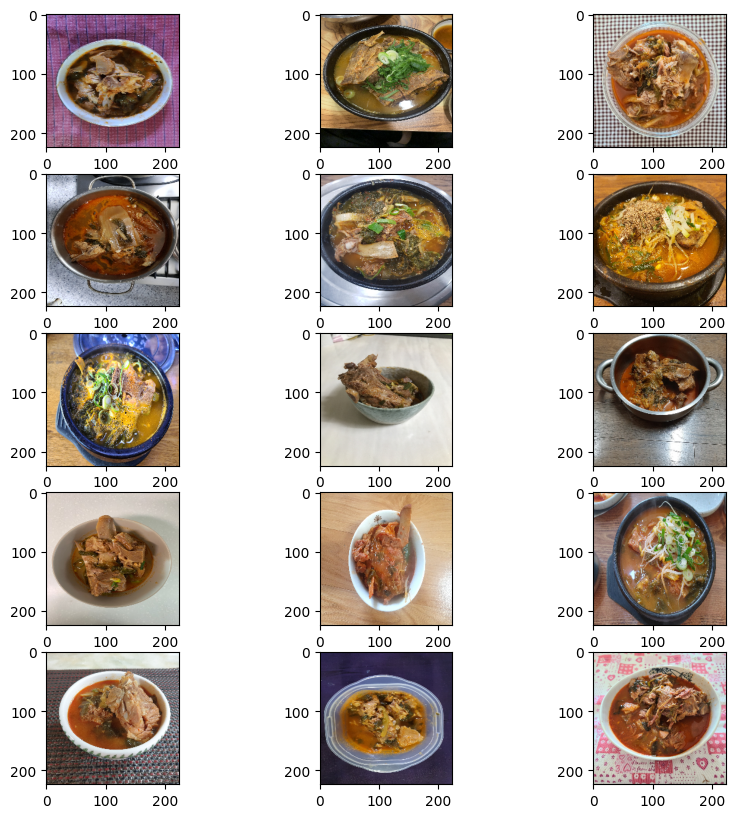

In [ ]:
back_list = []
back_path = all_img_path[:50]
for i in back_path:
    back_image = cv2.imread(i)
    back_image = cv2.cvtColor(back_image, cv2.COLOR_BGR2RGB)
    back_image = cv2.resize(back_image, (224,224))
    back_list.append(back_image)

fig = plt.figure(figsize=(10,10))
for i, img in enumerate(back_list[:15]):
    plt.subplot(5, 3, i+1)
    plt.imshow(img)
#plt.tight_layout()
#plt.show()

## 2) Split train / valid set

현재 label들이 shuffle되어있지 않은 상태이므로 섞는 과정을 추가함.
- 국 : 0 ~ 569  
- 탕 : 570 ~ 1709  
- 찌개 : 1710 ~ 2279  

In [ ]:
# Aa list of labels for each data point
all_labels = df['label']

# Indices for each class
indices_0 = [i for i, label in enumerate(all_labels) if label == 0]
indices_1 = [i for i, label in enumerate(all_labels) if label == 1]
indices_2 = [i for i, label in enumerate(all_labels) if label == 2]

# Shuffle the indices for each class
random.shuffle(indices_0)
random.shuffle(indices_1)
random.shuffle(indices_2)

# Calculate the split indices for each class
split_index_0 = int(len(indices_0) * 0.75)
split_index_1 = int(len(indices_1) * 0.75)
split_index_2 = int(len(indices_2) * 0.75)

# Split the indices for each class into training and validation sets
train_indices = indices_0[:split_index_0] + indices_1[:split_index_1] + indices_2[:split_index_2]
vali_indices = indices_0[split_index_0:] + indices_1[split_index_1:] + indices_2[split_index_2:]

# Shuffle the training and validation indices
random.shuffle(train_indices)
random.shuffle(vali_indices)

# Use the indices to get the corresponding image paths and labels
train_img_path = [all_img_path[i] for i in train_indices]
train_label = [all_label[i] for i in train_indices]

vali_img_path = [all_img_path[i] for i in vali_indices]
vali_label = [all_label[i] for i in vali_indices]

train_len = len(train_img_path)
vali_len = len(vali_img_path)

print("train set 길이 :", train_len)
print("validation set 길이 :", vali_len)

train set 길이 : 1708
validation set 길이 : 571


## 3) Transform

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`
- ref : https://pytorch.org/hub/pytorch_vision_densenet/

In [ ]:
mean = (0.485, 0.456, 0.406)
std =  (0.229, 0.224, 0.225)

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),###
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(mean, std) ###
])

## 4) DataLoader

In [ ]:
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)
# 1708 / 12 = 142.3x
# 571 / 12  = 47.58x
print("total train imgs :",train_len,'/total train batches :',train_batches)
print("total valid imgs :",vali_len,'/total valid batches :',vali_batches)

total train imgs : 1708 /total train batches : 214
total valid imgs : 571 /total valid batches : 72


# 4. Modeling

https://pytorch.org/vision/0.8/models.html

**summary**
- model : densenet161
- optimizer : adam
- loss func : crossentropyloss
- lr scheduler : steplr

In [ ]:
## 사이즈 에러
# RuntimeError: Given groups=1, weight of size [96, 1, 7, 7], expected input[12, 3, 224, 224] to have 1 channels, but got 3 channels instead
# class Case_model(nn.Module): #pytorch-image-models library
#     def __init__(self, name):
#         super(Case_model, self).__init__()
#         self.model = timm.create_model(name, pretrained = True, num_classes = CFG['CLASSES'], in_chans=3)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.model(x) ##
#         print('x size =', x.size)
#         return self.softmax(x)

# model =  Case_model(CFG['MODEL_NAME']).to(device)

In [ ]:
# # classifier
model = torchvision.models.densenet161(weights='DEFAULT').to(device) #### densenet161, densenet201 #### edit here #####

model.classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 160MB/s]


Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),  lr=CFG['LEARNING_RATE']) # Default lr = 0.001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

In [ ]:
def train(model, optimizer, train_loader, scheduler, device):
    model.to(device)
    n = len(train_loader)
    best_acc = 0

    for epoch in range(1, CFG["EPOCHS"]+1):
        model.train() #모델 학습
        running_loss = 0.0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad() #배치마다 optimizer 초기화

            logit = model(img) # 예측값 산출
            loss = criterion(logit, label)

            # Backpropagation
            loss.backward()
            optimizer.step() #가중치 최적화
            running_loss += loss.item()

        print("[%d] Train loss: %.10f"%(epoch, running_loss / len(train_loader)))

        if scheduler is not None:
            scheduler.step()

        #Validation set evaluation
        model.eval()

        vali_loss = 0.0
        correct = 0
        with torch.no_grad():
            for img, label in tqdm(iter(vali_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True) # 3개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item()

        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vali set: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))

        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), '/content/data/best_model.pth')  #/content/data/saved/best_model.pth
            print('Model Saved.')

# 5. Train

In [ ]:
train(model, optimizer, train_loader, scheduler, device)

100%|██████████| 214/214 [08:04<00:00,  2.26s/it]


[1] Train loss: 2.3092119890


100%|██████████| 72/72 [02:22<00:00,  1.98s/it]


Vali set: Loss: 0.5338, Accuracy: 483/571 (85%)

Model Saved.


100%|██████████| 214/214 [07:47<00:00,  2.18s/it]


[2] Train loss: 0.5709012505


100%|██████████| 72/72 [02:23<00:00,  1.99s/it]


Vali set: Loss: 0.3616, Accuracy: 499/571 (87%)

Model Saved.


100%|██████████| 214/214 [07:58<00:00,  2.24s/it]


[3] Train loss: 0.4267990805


100%|██████████| 72/72 [02:26<00:00,  2.03s/it]


Vali set: Loss: 0.3499, Accuracy: 500/571 (88%)

Model Saved.


100%|██████████| 214/214 [07:48<00:00,  2.19s/it]


[4] Train loss: 0.3350146602


100%|██████████| 72/72 [02:24<00:00,  2.00s/it]


Vali set: Loss: 0.2736, Accuracy: 519/571 (91%)

Model Saved.


100%|██████████| 214/214 [07:47<00:00,  2.18s/it]


[5] Train loss: 0.2937965857


100%|██████████| 72/72 [02:24<00:00,  2.01s/it]


Vali set: Loss: 0.4041, Accuracy: 495/571 (87%)



100%|██████████| 214/214 [07:47<00:00,  2.18s/it]


[6] Train loss: 0.2595834363


100%|██████████| 72/72 [02:23<00:00,  1.99s/it]


Vali set: Loss: 0.2966, Accuracy: 511/571 (89%)



100%|██████████| 214/214 [07:45<00:00,  2.18s/it]


[7] Train loss: 0.2550162187


100%|██████████| 72/72 [02:22<00:00,  1.98s/it]


Vali set: Loss: 0.2637, Accuracy: 523/571 (92%)

Model Saved.


100%|██████████| 214/214 [07:46<00:00,  2.18s/it]


[8] Train loss: 0.1975849631


100%|██████████| 72/72 [02:23<00:00,  2.00s/it]


Vali set: Loss: 0.2975, Accuracy: 509/571 (89%)



100%|██████████| 214/214 [07:42<00:00,  2.16s/it]


[9] Train loss: 0.1578685619


100%|██████████| 72/72 [02:23<00:00,  2.00s/it]


Vali set: Loss: 0.2335, Accuracy: 521/571 (91%)



100%|██████████| 214/214 [07:52<00:00,  2.21s/it]


[10] Train loss: 0.1488369235


100%|██████████| 72/72 [02:25<00:00,  2.02s/it]


Vali set: Loss: 0.2278, Accuracy: 525/571 (92%)

Model Saved.


# 6. Prediction (on raw dataset)

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/data/best_model.pth')
model = torchvision.models.densenet161(weights='DEFAULT').to(device) #### edit here #####
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


[0, 0, 0, 1, 0]

실제 정답 = 00000

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/EWHA/Term Project/test.csv')
test_df = test_df.iloc[:, 1:4]
test_df = test_df.rename(columns={'cat':'label'})
test_df.head()

,id,img_path,label
0,TEST_0,./train/TEST_0.jpg,0
1,TEST_1,./train/TEST_1.jpg,0
2,TEST_2,./train/TEST_2.jpg,0
3,TEST_3,./train/TEST_3.jpg,0
4,TEST_4,./train/TEST_4.jpg,0


In [ ]:
test_img_path[:5]

['/content/data/test/content/test/TEST_0.png',
 '/content/data/test/content/test/TEST_1.png',
 '/content/data/test/content/test/TEST_2.png',
 '/content/data/test/content/test/TEST_3.png',
 '/content/data/test/content/test/TEST_4.png']

In [ ]:
answers = test_df['label']

In [ ]:
def accuracy(pred, ans):
  """
  둘다 리스트
  """
  cnt = 0
  for i in range(len(pred)):
    if(pred[i] == ans[i]):
      cnt += 1
  return cnt / len(pred) * 100

In [ ]:
print('Accuracy = ', accuracy(preds, answers))

Accuracy =  91.66666666666666
